# Damage Classification

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
#export
from xview2comp.nb_02c import *

### Data

In [28]:
SOURCE = Path('data/train')
SOURCE.ls()

[PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/images')]

In [29]:
annots = pd.read_csv(SOURCE/'classification_images'/'class_labels_train.csv')

In [30]:
annots.head()

,damage,uid
0,no-damage,14747210-cd03-44ff-9d69-8439e47c9b92
1,no-damage,5b5ab817-d4ab-4f74-ba8c-adf9ad914b49
2,no-damage,60702ccb-94f5-4de9-9e5c-f78753cf1c79
3,no-damage,9abd492c-5f2e-4c3a-805b-9893623abc1a
4,no-damage,86f52d79-4cf4-48ec-b534-14f4ef2597d9


In [32]:
annots.damage.value_counts()

no-damage        117426
minor-damage      14980
major-damage      14161
destroyed         13227
un-classified      2993
Name: damage, dtype: int64

In [39]:
#export
def combine_nodamage_unclassified(annots):
    base_level = 'no-damage/un-classified'
    df = annots.copy()
    df.damage.replace('no-damage', base_level, inplace=True)
    df.damage.replace('un-classified', base_level, inplace=True)
    return df

In [40]:
annots = combine_nodamage_unclassified(annots)
annots.damage.value_counts()

no-damage/un-classified    120419
minor-damage                14980
major-damage                14161
destroyed                   13227
Name: damage, dtype: int64

In [41]:
fnames = [SOURCE/'classification_images'/f'{o}.png' for o in datadf.uid]
fnames[:3]

[PosixPath('data/train/classification_images/7ae792ae-64b5-41ec-be7b-14873c450650.png'),
 PosixPath('data/train/classification_images/4ca98eb5-10bd-4d75-b3b3-3b9012291c1f.png'),
 PosixPath('data/train/classification_images/22e5eb6a-f924-4b27-9cb0-90b112bcfd66.png')]

In [42]:
val_idx = get_random_val_idx(len(fnames))    

In [45]:
#export
def get_label(annots, fname): 
    return annots[annots.uid == fname.stem].damage.values[0]

In [46]:
cats = list(annots.damage.value_counts().index)
cats

['no-damage/un-classified', 'minor-damage', 'major-damage', 'destroyed']

In [47]:
src = (ImageList(fnames)
       .split_by_idx(val_idx)
       .label_from_func(partial(get_label, annots), classes=cats))

In [49]:
bs = 32
sz = 512
tfms = get_transforms(flip_vert=True, max_rotate=.2, max_warp=0., max_zoom=1.1, max_lighting=.4)
data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [50]:
data

ImageDataBunch;

Train: LabelList (809 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no-damage/un-classified,no-damage/un-classified,no-damage/un-classified,no-damage/un-classified,no-damage/un-classified
Path: .;

Valid: LabelList (89 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no-damage/un-classified,no-damage/un-classified,no-damage/un-classified,destroyed,no-damage/un-classified
Path: .;

Test: None

no-damage/un-classified
data/train/classification_images/8e150943-54f4-4ca0-b2c2-6610d9824b7c.png


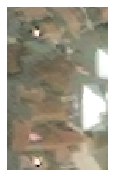

In [51]:
idx = 11
data.valid_ds.x[idx].show()
print(data.valid_ds.y[idx], data.valid_ds.items[idx], sep='\n')

In [52]:
data.train_ds.classes

['no-damage/un-classified', 'minor-damage', 'major-damage', 'destroyed']

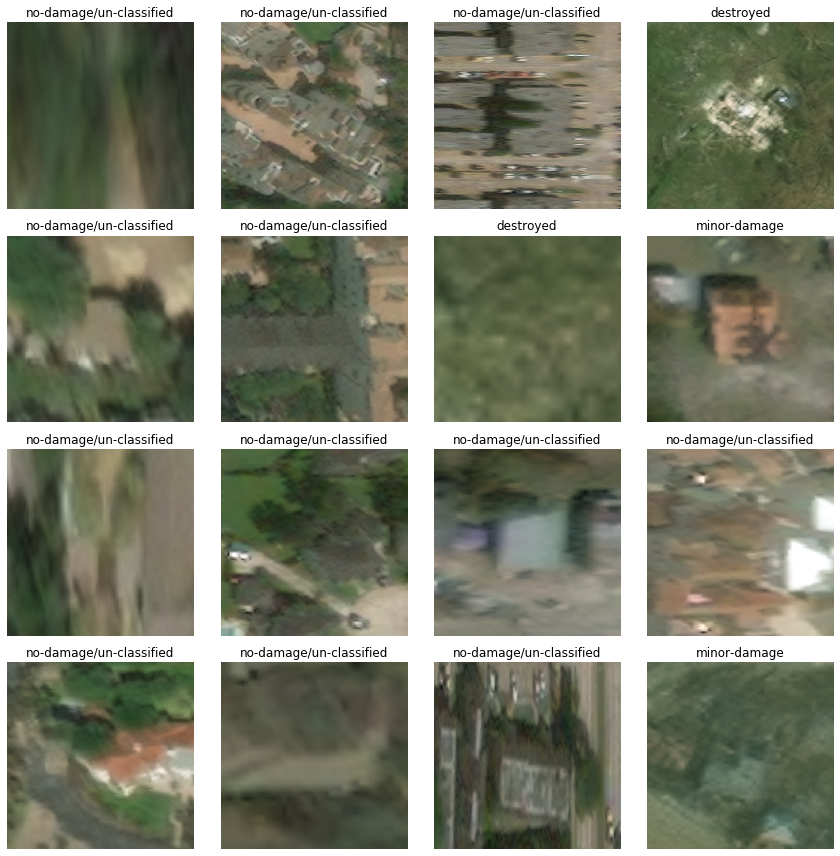

In [53]:
data.show_batch(rows=4, figsize=(12, 12), ds_type=DatasetType.Valid)

In [54]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training

In [56]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


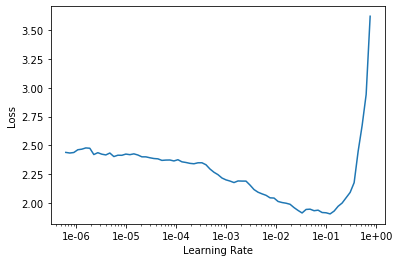

In [59]:
learn.recorder.plot()

In [60]:
lr = 1e-2

In [61]:
learn.fit_one_cycle(1, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.770817,0.861595,0.258427,00:19


In [63]:
learn.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.009323,0.818459,0.213483,00:17
1,0.881529,1.472590,0.337079,00:17
2,0.875073,0.637081,0.269663,00:17
3,0.767877,0.471066,0.202247,00:17
4,0.671327,0.450524,0.202247,00:17


In [64]:
learn.fit_one_cycle(10, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.507649,0.482108,0.168539,00:17
1,0.543812,0.628817,0.168539,00:17
2,0.597118,1.048085,0.303371,00:17
3,0.660338,0.760741,0.247191,00:17
4,0.621974,0.431341,0.179775,00:17
5,0.605951,0.430387,0.202247,00:17
6,0.554475,0.285629,0.123596,00:17
7,0.510151,0.302275,0.123596,00:17
8,0.457609,0.271911,0.101124,00:17
9,0.417087,0.280145,0.101124,00:17


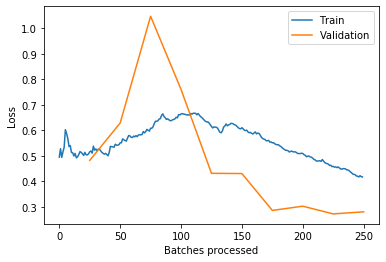

In [65]:
learn.recorder.plot_losses()

In [67]:
learn.save('classifier_sz512_bs32_resnet50_stage1')
learn.load('classifier_sz512_bs32_resnet50_stage1');

# -fin

In [68]:
! python notebook2script.py 03_damage_classification.ipynb

Converted 03_damage_classification.ipynb to xview2comp/nb_03.py
